**Learning Sparse Codes with Entropy-Based ELBOs**

*Dmytro Velychko, Simon Damm, Asja Fischer, Jörg Lücke*

Learning sparse bars dataset.

Author: Dmytro Velychko, Carl von Ossietzky University of Oldenburg

Email: dmytro.velychko@uni-oldenburg.de

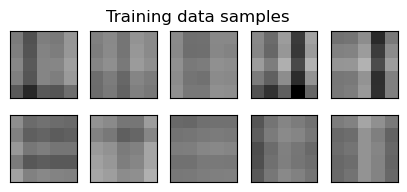

In [1]:
import os
from datetime import datetime
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets.bars import BarsDataset
from models.optimalmanifoldELBO import OptimalManifoldSC, DiagCovarGaussianVariationalParams, FullCovarGaussianVariationalParams, AmortizedGaussianVariationalParams
from models.stochasticELBO import StochasticSC
from models.analyticELBO import AnalyticELBOSC
from utils.training import *
from utils.plotting import *
%matplotlib inline

torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
#device = "cpu"


if False:
    seed = 123456
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


N = 1000
H = 2*5  # number of sources
D = int(H / 2)**2  # data dimensionality
dataset = BarsDataset(N, D, H, latent="Laplace")
#H += 2  # additional latent dimensions

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000)

likelihood_entropies = []
prior_entropies = []
proposal_entropies = []
def on_compute_entropy(likelihood_entropy, prior_entropy, proposal_entropy):
    likelihood_entropies.append(likelihood_entropy.item())
    prior_entropies.append(prior_entropy.item())
    proposal_entropies.append(proposal_entropy.item())

model = OptimalManifoldSC(N, D, H, 
        variationalparams=FullCovarGaussianVariationalParams(N, D, H), 
        on_compute_entropy=on_compute_entropy).to(device)

path = "./out/bars/" + model.__class__.__name__ + "/" + datetime.now().strftime('%y.%m.%d-%H:%M:%S') + "/"
if not os.path.exists(path):
    os.makedirs(path)
prefix = path

plot_training_data(dataset.x[:H])
plt.suptitle("Training data samples")
plt.show()

In [2]:

def save_plots(model, epoch, elbos=None):
    if epoch % 10 == 0:
        plot(elbos, filename=prefix + "elbos.pdf")
        plot_Ws(model, filename=prefix + "Ws-{:05}.pdf".format(epoch))
    
    if epoch % 10 == 0:
        indexes = range(10)
        x = dataset.x[indexes]
        plot_samples(model, x, indexes, filename=prefix + "X-{:05}.pdf".format(epoch))

save_plots(model, epoch=0)

model.prior_scale = 1
elbos, gradsizes = train_LBFGS(model, dataloader, nepochs=1000, on_epoch=save_plots, 
    history_size=200, 
    max_iter=200)

save_plots(model, 10000)
plt.plot(gradsizes)
plt.gca().set_yscale("log")
plt.title("gradient size")
plt.savefig(prefix + "gradsizes.pdf")
plt.close()

Epoch    0 	 Batch    0 	 ELBO: -55.005585 	Gradient size: 0.124587
Epoch    1 	 Batch    0 	 ELBO: -9.450226 	Gradient size: 0.075237
Epoch    2 	 Batch    0 	 ELBO: -9.168257 	Gradient size: 0.038725
Epoch    3 	 Batch    0 	 ELBO: -9.025075 	Gradient size: 0.030489
Epoch    4 	 Batch    0 	 ELBO: -8.952417 	Gradient size: 0.014196
Epoch    5 	 Batch    0 	 ELBO: -8.869276 	Gradient size: 0.012596
Epoch    6 	 Batch    0 	 ELBO: -8.821123 	Gradient size: 0.010279
Epoch    7 	 Batch    0 	 ELBO: -8.797575 	Gradient size: 0.005139
Epoch    8 	 Batch    0 	 ELBO: -8.784758 	Gradient size: 0.002718
Epoch    9 	 Batch    0 	 ELBO: -8.782334 	Gradient size: 0.002718
Epoch   10 	 Batch    0 	 ELBO: -8.782334 	Gradient size: 0.002718
Epoch   11 	 Batch    0 	 ELBO: -8.782334 	Gradient size: 0.002718


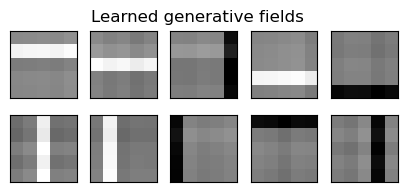

In [3]:
plot_Ws(model)
plt.suptitle("Learned generative fields")
plt.show()

In [4]:
# Set ground-truth W and compute max ELBO
with torch.no_grad():
    model.W.copy_(torch.Tensor(dataset.gen.W))
data = dataset.x.type(torch.get_default_dtype()).to(model.device)
gt_elbo = optimize_latents(model, data, indexes=range(len(data)), init=False, max_iter=200)
print("Ground truth ELBO: {}".format(gt_elbo))
np.savetxt(prefix + "groundtruth-elbo.txt", np.array([gt_elbo]), fmt="%f", delimiter=",")

Ground truth ELBO: -8.883783340454102
